## Predicting INTEL share price with
## 1. Linear regression
## 2. KNN
## 3. ARIMA
## 4. Facebook Prophet 


It will also be interesting to explore how other time series forecasting techniques such as ARIMA and Facebook Prophet perform in stock price prediction and see how their performances compare with the algorithms above.



In [1]:
#importing all necessary libraries

import pandas as pd
import numpy as np

# for reproducibility of our results
np.random.seed(1234)

from datetime import date
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [2]:
# pre-set the plot font sizes...

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [3]:
def calc_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


def calc_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean(np.power((y_true - y_pred),2)))
    return rmse

In [4]:
#load data
df = pd.read_csv('data/intel_shares.csv')
#quick check of dimensions of loaded file
df.shape


(1090, 13)

In [5]:
#remove duplicates, if any (suppose no, as data is cleaned)
# Drop duplicates
df = df.drop_duplicates()
print(df.shape)

# convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df.head(3)
#check column data types
df.dtypes


(1090, 13)


Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
Dividend             float64
Split                  int64
Adj_Open             float64
Adj_High             float64
Adj_Low              float64
Adj_Close            float64
Adj_Volume             int64
dtype: object

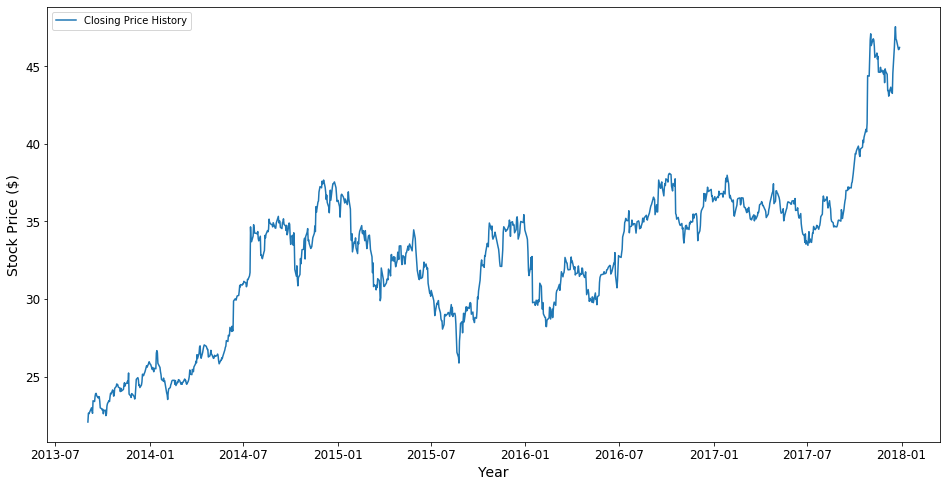

In [6]:
#visualize time series - Date vs Close

#all sizes for annotations specified above,standard for all pictures 

plt.figure(figsize = (16,8))
plt.plot(df['Date'], df['Close'], label = 'Closing Price History')
plt.legend(loc = "upper left")
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.show()

#### Split data into train and test set for moving average calculations

The moving average is calculated by taking the average of a set of the most recent historical values. For each subsequent step, the predicted values are taken into consideration while removing the oldest observed values from the set. To implement this technique, the first step is to create a dataframe that contains only the Date and Close columns, then split the data into a validation set of last year’s data and a training set of data from 2 years before the train data sets to verify the predictions. Lastly, generate predicted prices and check RSME using actual values (Investopedia).

In [7]:
# sort by datetime (otherwise all data is in random order, first train data, than test data)
df.sort_values(by='Date', inplace=True, ascending=True)

#splitting into train and validation
train = df[:787]
valid = df[787:]


df.shape, train.shape, valid.shape


((1090, 13), (787, 13), (303, 13))

In [8]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()


(Timestamp('2013-09-03 00:00:00'),
 Timestamp('2016-10-14 00:00:00'),
 Timestamp('2016-10-17 00:00:00'),
 Timestamp('2017-12-28 00:00:00'))

In [9]:
#make predictions
preds = []
for i in range(0, valid.shape[0]):
    a = train['Close'][len(train) - valid.shape[0] + i:].sum() + valid['Close'][:i].sum()
    b = a/valid.shape[0]
    preds.append(b)

C:\Users\dave_\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


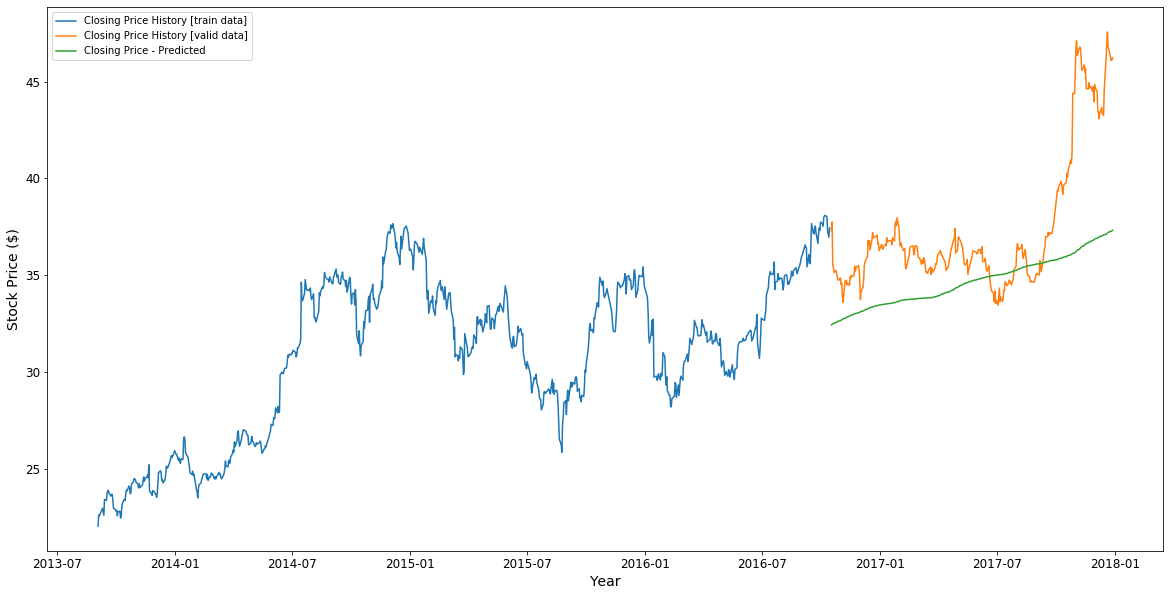

In [10]:
# Plot predicted price vs actual closing price 

# moving average -> predictions
valid['Predictions_ma'] = preds
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(train['Date'], train['Close'], label = 'Closing Price History [train data]')
plt.plot(valid['Date'], valid['Close'], label = 'Closing Price History [valid data]')
plt.plot(valid['Date'], valid['Predictions_ma'], label = 'Closing Price - Predicted')
plt.legend(loc = "upper left")
plt.show()

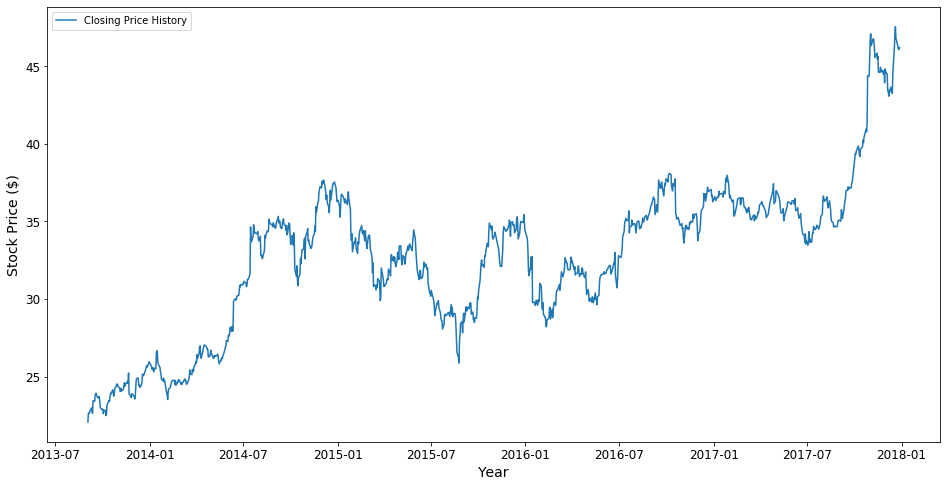

In [11]:
plt.figure(figsize = (16,8))
plt.plot(df['Date'], df['Close'], label = 'Closing Price History')
plt.legend(loc = "upper left")
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.show()

#### Linear regression
The Linear regression model determines the relationship between the independent variable and the dependent variables and returns and equations for the line of best fit. 

Where x1, x2,….xn represent the independent variables while the coefficients θ1, θ2, …. θn represent the weights.
In this case, the independent variable is the Date. To implement this technique, the dataset was sorted in ascending order and then a separate dataset was created to allow for new features to be added without affecting the original data. Next, the data was split into train and validation sets to check the performance of the model (Yale).

We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [13]:
#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(df)):
    new_data['Date'][i] = df['Date'][i]
    new_data['Close'][i] = df['Close'][i]


In [14]:
new_data.head(3)

,Date,Close
0,2017-12-28 00:00:00,46.22
1,2017-12-27 00:00:00,46.11
2,2017-12-26 00:00:00,46.08


This creates features such as:

‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’.

Note: I have used add_datepart from fastai library. If you do not have it installed, you can simply use the command pip install fastai. Otherwise, you can create these feature using simple for loops in python. I have shown an example below.

Apart from this, we can add our own set of features that we believe would be relevant for the predictions. For instance, my hypothesis is that the first and last days of the week could potentially affect the closing price of the stock far more than the other days. So I have created a feature that identifies whether a given day is Monday/Friday or Tuesday/Wednesday/Thursday. This can be done using the following lines of code:


https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/


from https://github.com/fastai/fastai_old/blob/master/dev_nb/x_009a_rossman_data_clean.ipynb

In [14]:
import re
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [15]:
#create features, to distiguish between days of the week, that can have an affect on stock price
#need add_datepart old library for this
#from fastai import add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
new_data['mon_fri'] = 0


In [16]:
new_data.head(3)

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon_fri
0,46.22,2017,12,52,28,3,362,False,False,False,False,False,False,0
1,46.11,2017,12,52,27,2,361,False,False,False,False,False,False,0
2,46.08,2017,12,52,26,1,360,False,False,False,False,False,False,0


In [17]:
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0
#split into train and validation
train = new_data[:987]
valid = new_data[987:]
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

preds_linear_regression = model.predict(x_valid)

C:\Users\dave_\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\dave_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
valid.head(3)

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon_fri
987,24.68,2014,1,5,29,2,29,False,False,False,False,False,False,0
988,24.9,2014,1,5,28,1,28,False,False,False,False,False,False,0
989,24.72,2014,1,5,27,0,27,False,False,False,False,False,False,1


In [19]:
valid['mydate'] = pd.to_datetime(valid[['Year', 'Month', 'Day']])
valid.head(3)

C:\Users\dave_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon_fri,mydate
987,24.68,2014,1,5,29,2,29,False,False,False,False,False,False,0,2014-01-29
988,24.9,2014,1,5,28,1,28,False,False,False,False,False,False,0,2014-01-28
989,24.72,2014,1,5,27,0,27,False,False,False,False,False,False,1,2014-01-27


C:\Users\dave_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


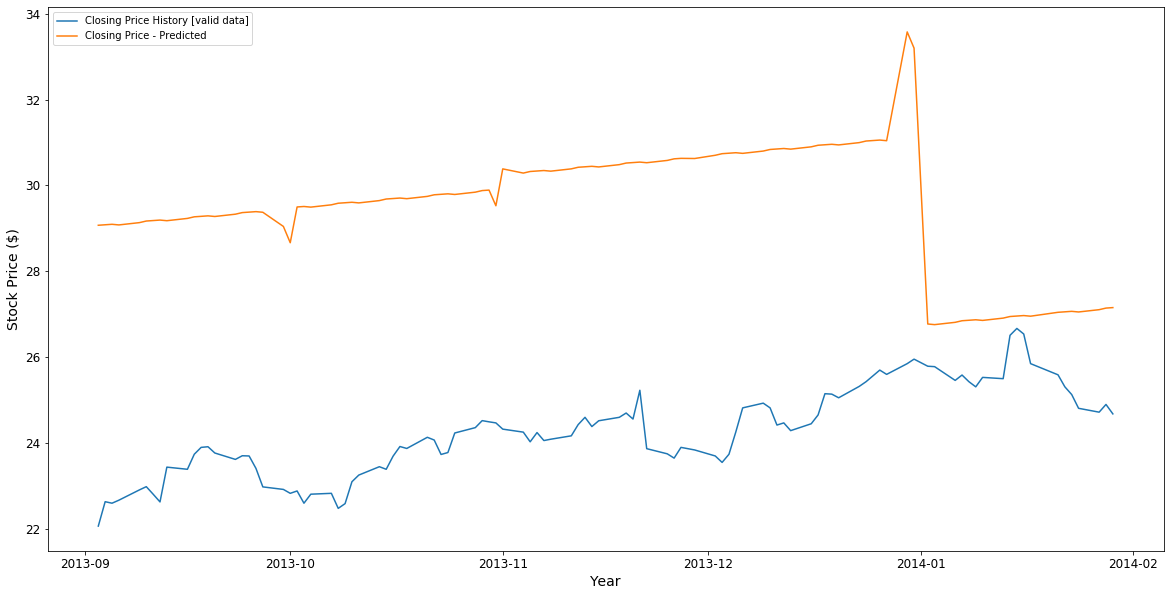

In [20]:
valid['Predictions_linear_regression'] = preds_linear_regression
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
#plt.plot(train['Date'], train['Close'], label = 'Closing Price History [train data]')
plt.plot(valid['mydate'], valid['Close'], label = 'Closing Price History [valid data]')
plt.plot(valid['mydate'], valid['Predictions_linear_regression'], label = 'Closing Price - Predicted')
plt.legend(loc = "upper left")
plt.show()

Predictions with linear regression are too far from real values.
It is obviuos on the plot.

Linear regression is a simple technique and quite easy to interpret, but there are a few obvious disadvantages. One problem in using regression algorithms is that the model overfits to the date and month column. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago, or the same date/month a year ago.

As seen from the plot above, for January 2016 and January 2017, there was a drop in the stock price. The model has predicted the same for January 2018. A linear regression technique can perform well for problems such as Big Mart sales where the independent features are useful for determining the target value.



#### k-Nearest Neighbor (kNN) 
kNN is based on the independent variable and finds a similarity between the new data points and old points. Future price is predicted based on the average of its neighbour data point.
In pattern recognition, the k-nearest neighbour’s algorithm (k-NN) is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space (Yale).

In [21]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
#Using the same train and validation set from the last section:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)
#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
#fit the model and make predictions
model.fit(x_train,y_train)
preds_knn = model.predict(x_valid)

In [22]:
valid['Predictions_knn'] = preds_knn
valid.head(3)

C:\Users\dave_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon_fri,mydate,Predictions_linear_regression,Predictions_knn
987,24.68,2014,1,5,29,2,29,False,False,False,False,False,False,0,2014-01-29,27.155131,35.86
988,24.9,2014,1,5,28,1,28,False,False,False,False,False,False,0,2014-01-28,27.143956,35.6622
989,24.72,2014,1,5,27,0,27,False,False,False,False,False,False,1,2014-01-27,27.106929,34.3467


C:\Users\dave_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


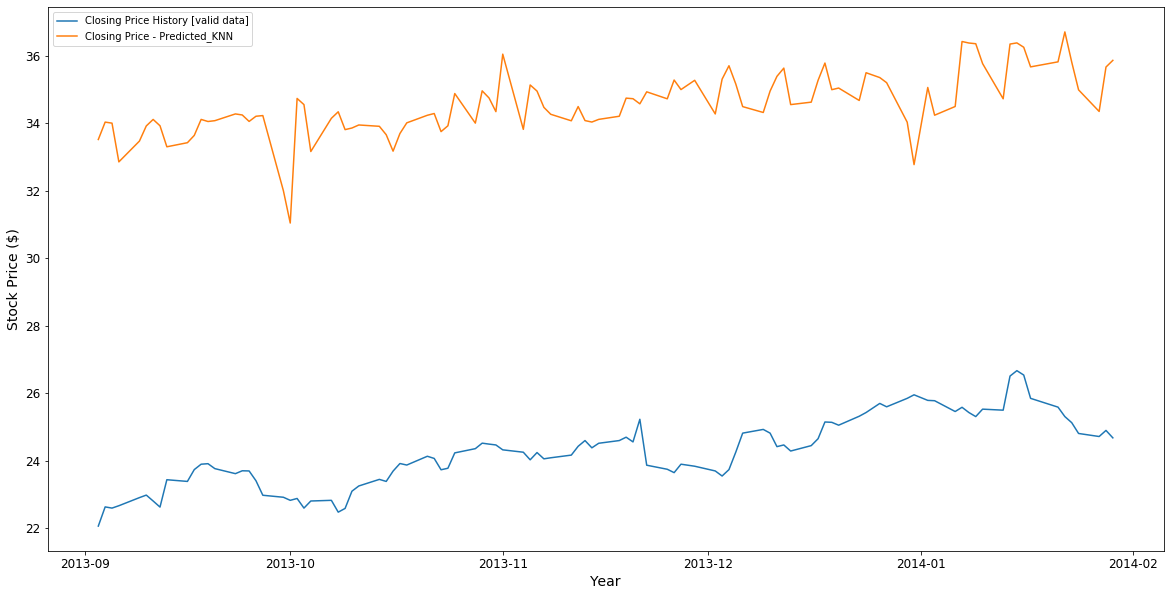

In [23]:
valid['Predictions_knn'] = preds_knn
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(valid['mydate'], valid['Close'], label = 'Closing Price History [valid data]')
plt.plot(valid['mydate'], valid['Predictions_knn'], label = 'Closing Price - Predicted_KNN')
plt.legend(loc = "upper left")
plt.show()

#### Auto ARIMA (Auto-Regressive Integrated Moving Averages)
ARIMA is a statistical method for time series forecasting. ARIMA stands for Auto-Regressive Integrated Moving Averages. 

ARIMA models work on the following assumptions — The data series is stationary, which means that the mean and variance should not vary with time. ARIMA models 3 main parameters to predict future values based on past values. There are three types of parameters:
p — past values used for forecasting the next value
q — past forecast errors used to predict the future values
d — order of differencing
For this project, auto ARIMA was used which automatically selects the best combination of (p, q, d) that provide the least error 
ARIMA is a very popular technique for time series modeling. It describes the correlation between data points and takes into account the difference of the values. An improvement over ARIMA is SARIMA (or seasonal ARIMA).


ARIMA has three components – AR (autoregressive term), I (differencing term) and MA (moving average term). Let us understand each of these components –

AR term refers to the past values used for forecasting the next value. The AR term is defined by the parameter ‘p’ in arima. The value of ‘p’ is determined using the PACF plot.
MA term is used to defines number of past forecast errors used to predict the future values. The parameter ‘q’ in arima represents the MA term. ACF plot is used to identify the correct ‘q’ value.
Order of differencing  specifies the number of times the differencing operation is performed on series to make it stationary. Test like ADF and KPSS can be used to determine whether the series is stationary and help in identifying the d value.


1. Load the data: The first step for model building is of course to load the dataset
2. Preprocessing: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
3. Make series stationary: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
4. Determine d value: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
5. Create ACF and PACF plots: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
6. Determine the p and q values: Read the values of p and q from the plots in the previous step
7. Fit ARIMA model: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
8. Predict values on validation set: Predict the future values
9. Calculate RMSE: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set

Why do we need Auto ARIMA?
Although ARIMA is a very powerful model for forecasting time series data, the data preparation and parameter tuning processes end up being really time consuming. Before implementing ARIMA, you need to make the series stationary, and determine the values of p and q using the plots we discussed above. Auto ARIMA makes this task really simple for us as it eliminates steps 3 to 6 we saw in the previous section. Below are the steps you should follow for implementing auto ARIMA:

1. Load the data: This step will be the same. Load the data into your notebook
2. Preprocessing data: The input should be univariate, hence drop the other columns
3. Fit Auto ARIMA: Fit the model on the univariate series
4. Predict values on validation set: Make predictions on the validation set
5. Calculate RMSE: Check the performance of the model using the predicted values against the actual values
We completely bypassed the selection of p and q feature.


https://pypi.org/project/pmdarima/



In [60]:
#pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\dave_\Anaconda3\python.exe -m pip install --upgrade pip' command.


#### Test for Stationarity
Stationarity is an important concept in time-series and any time-series data should undergo a stationarity test before proceeding with a model.
We use the ‘Augmented Dickey-Fuller Test’ to check whether the data is stationary or not which is available in the ‘pmdarima’ package.

In [49]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df)

# Fit your model
#works
model = pm.auto_arima(train, seasonal=True, m=12)
all values are the same! wrong prediction

#doesnt work
model = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)


In [50]:
import pmdarima as pm
data = df.sort_index(ascending=True, axis=0)
train = data[:787]
valid = data[787:]
training = train['Close']
validation = valid['Close']
model = pm.auto_arima(training, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, 
                      start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,error_action='ignore', seasonal=True, m=12,
                     supress_warning=True, stepwise=True, random_state=20, n_fits=50)

model.fit(training)
forecast = model.predict(n_periods=303)                      
                      

In [51]:
valid.head(3)

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
787,2014-11-12,33.23,33.42,33.000,33.38,22864222,0.0,1,28.210412,28.371711,28.015155,28.337754,22864222
788,2014-11-11,33.36,33.54,33.195,33.31,19676704,0.0,1,28.320775,28.473585,28.180699,28.278328,19676704
789,2014-11-10,33.43,33.49,33.080,33.26,30653627,0.0,1,28.380201,28.431138,28.083070,28.235880,30653627


In [52]:
valid['Predictions_arima'] = forecast
valid.head(3)

C:\Users\dave_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,Predictions_arima
787,2014-11-12,33.23,33.42,33.000,33.38,22864222,0.0,1,28.210412,28.371711,28.015155,28.337754,22864222,33.378770
788,2014-11-11,33.36,33.54,33.195,33.31,19676704,0.0,1,28.320775,28.473585,28.180699,28.278328,19676704,33.391566
789,2014-11-10,33.43,33.49,33.080,33.26,30653627,0.0,1,28.380201,28.431138,28.083070,28.235880,30653627,33.500205


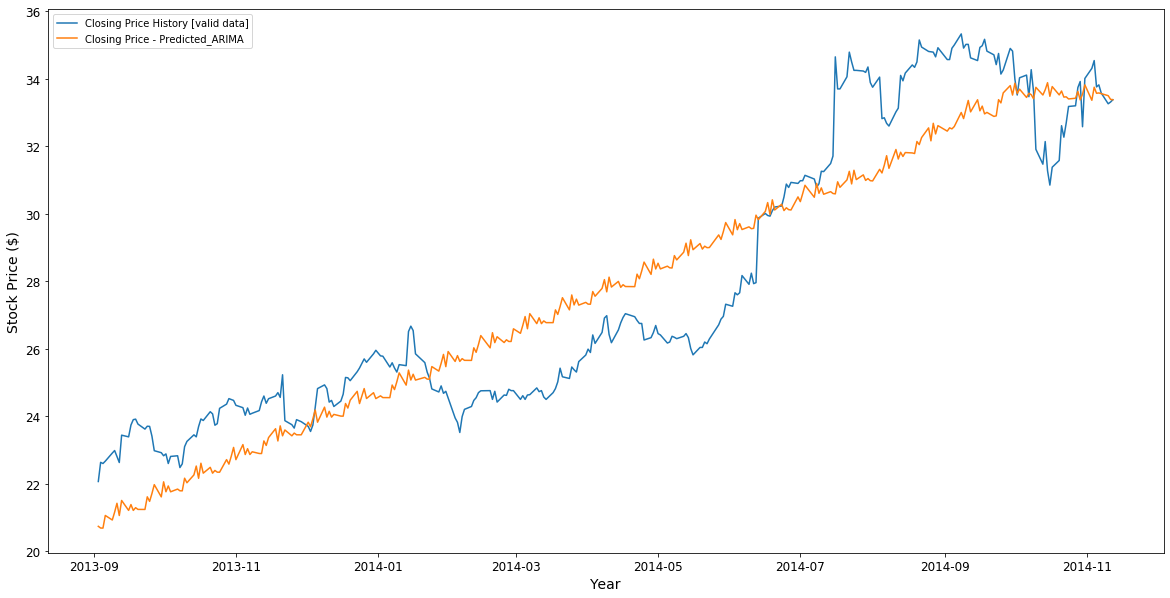

In [53]:
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(valid['Date'], valid['Close'], label = 'Closing Price History [valid data]')
plt.plot(valid['Date'], valid['Predictions_arima'], label = 'Closing Price - Predicted_ARIMA')
plt.legend(loc = "upper left")
plt.show()

In [54]:
valid.head(3)

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,Predictions_arima
787,2014-11-12,33.23,33.42,33.000,33.38,22864222,0.0,1,28.210412,28.371711,28.015155,28.337754,22864222,33.378770
788,2014-11-11,33.36,33.54,33.195,33.31,19676704,0.0,1,28.320775,28.473585,28.180699,28.278328,19676704,33.391566
789,2014-11-10,33.43,33.49,33.080,33.26,30653627,0.0,1,28.380201,28.431138,28.083070,28.235880,30653627,33.500205


In [55]:
valid.tail(5)

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,Predictions_arima
1085,2013-09-09,22.72,23.03,22.70,22.910,27770600,0.0,1,18.515485,18.768117,18.499186,18.670324,27770600,20.926594
1086,2013-09-06,22.69,22.82,22.40,22.670,27606600,0.0,1,18.491037,18.596979,18.254703,18.474738,27606600,21.060973
1087,2013-09-05,22.68,22.73,22.49,22.600,22552800,0.0,1,18.482887,18.523634,18.328048,18.417692,22552800,20.686651
1088,2013-09-04,22.38,22.78,22.28,22.635,37941800,0.0,1,18.238405,18.564381,18.156910,18.446215,37941800,20.688128
1089,2013-09-03,22.21,22.24,21.97,22.067,26427300,0.0,1,18.099864,18.124313,17.904278,17.983328,26427300,20.738768


#### Prophet
Prophet pioneered by Facebook is a time series forecasting library that requires no data preprocessing. The model takes a dataframe with two columns, data (ds) and target (y) and captures the trend and seasonality in past data (Towards Data Science).

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.


To use Prophet for forecasting, first, a Prophet() object is defined and configured, then it is fit on the dataset by calling the fit() function and passing the data.

The Prophet() object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more. By default, the model will work hard to figure out almost everything automatically.

The fit() function takes a DataFrame of time series data. The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.

This means we change the column names in the dataset. It also requires that the first column be converted to date-time objects, if they are not already (e.g. this can be down as part of loading the dataset with the right arguments to read_csv).


In [13]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Importing matplotlib failed. Plotting will not work.
Importing plotly failed. Interactive plots will not work.


Prophet 0.7.1


In [22]:
#importing prophet
from fbprophet import Prophet

#creating a separate dataset
new_data2 = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(df)):
    new_data2['Date'][i] = df['Date'][i]
    new_data2['Close'][i] = df['Close'][i]

new_data2.head(3)


,Date,Close
0,2017-12-28 00:00:00,46.22
1,2017-12-27 00:00:00,46.11
2,2017-12-26 00:00:00,46.08


In [24]:
#convert to datetime
new_data2['Date'] = pd.to_datetime(new_data2.Date,format='%Y-%m-%d')
new_data2.index = new_data2['Date']

#preparing data for fb prophet
new_data2.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
#train and validation
train = new_data2[:987]
valid = new_data2[987:]


In [25]:
train.head(3)

,ds,y
Date,,
2017-12-28,2017-12-28,46.22
2017-12-27,2017-12-27,46.11
2017-12-26,2017-12-26,46.08


In [26]:
#fit the model
model = Prophet()
model.fit(train)
#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)
forecast.head(3)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-30,22.658358,21.649493,25.127168,22.658358,22.658358,0.765091,0.765091,0.765091,-0.388700,-0.388700,-0.388700,1.153791,1.153791,1.153791,0.0,0.0,0.0,23.423449
1,2014-01-31,22.726051,21.599840,25.154957,22.726051,22.726051,0.686165,0.686165,0.686165,-0.405041,-0.405041,-0.405041,1.091206,1.091206,1.091206,0.0,0.0,0.0,23.412215
2,2014-02-03,22.929129,21.630444,25.298832,22.929129,22.929129,0.518858,0.518858,0.518858,-0.398866,-0.398866,-0.398866,0.917724,0.917724,0.917724,0.0,0.0,0.0,23.447988


We are only concerned with ds, yhat_lower, yhat_upper, and yhat because these are the variables that will give us the predicted results with respect to the date specified.

yhat means the predicted output based on the input fed to the model, yhat_lower, and upper means the upper and lower value that can go based on the predicted output that is, the fluctuations that can happen.

#### Getting the desired columns


In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-30,23.423449,21.649493,25.127168
1,2014-01-31,23.412215,21.599840,25.154957
2,2014-02-03,23.447988,21.630444,25.298832
3,2014-02-04,23.503075,21.765397,25.256386
4,2014-02-05,23.528281,21.921330,25.400455


#### Plotting the outputplot 

we can see the predictions made by the Prophet library. The dotted lines represent the actual data points that we specified in the training part. The lines represent the predictions made. Also, we can see the predictions made on the unseen data that we created with only lines at the extreme right-hand side. For verification purposes, you can match the data frame timestamps with the graph.

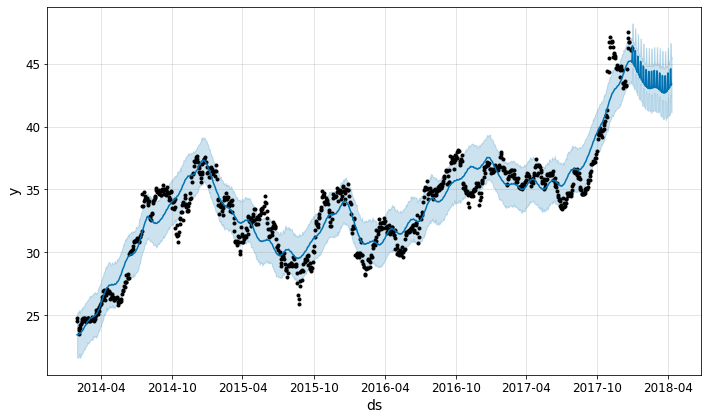

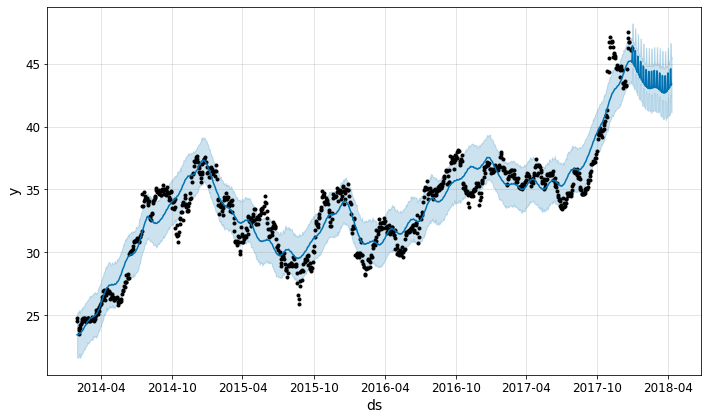

In [28]:
model.plot(forecast)

##### Checking the trends in the data: 
Below we can see the trends with respect to year and months in the year. The first graph represents an increasing trend as we progress in the years and the latter shows a fluctuating trend in the monthly milk sales. For some months it is low while for some it is high.

As mentioned in the starting Prophet estimates the trend and weekly_seasonality based on the training data.

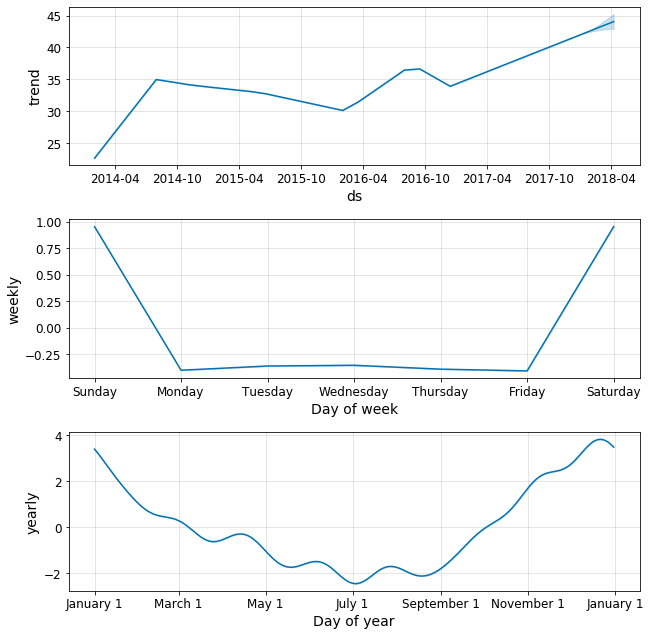

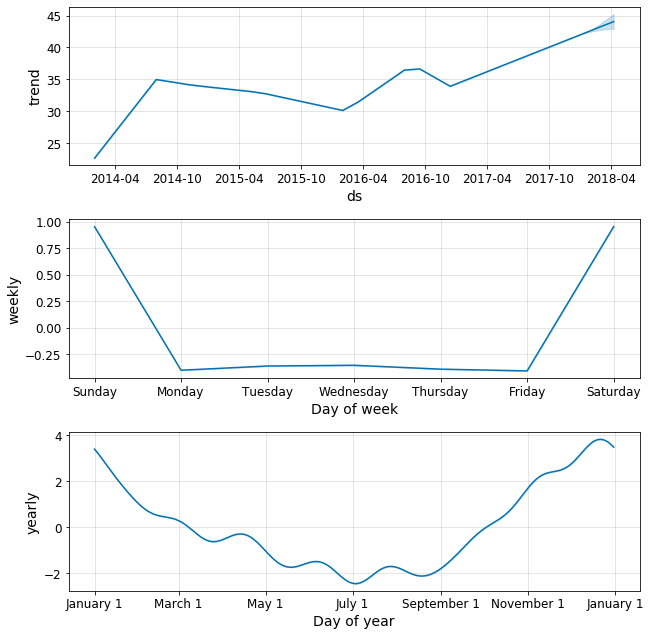

In [29]:
model.plot_components(forecast)


we will see some of the useful functions present in the library fbprophet listed below with an example.
Prophet.fit
Prophet.predict
Prophet.plot
Prophet.plot_components
Prophet.add_seasonality
Prophet.add_regressors
Prophet.seasonalities
Prophet.predictive_samples

In [ ]:
#df sort


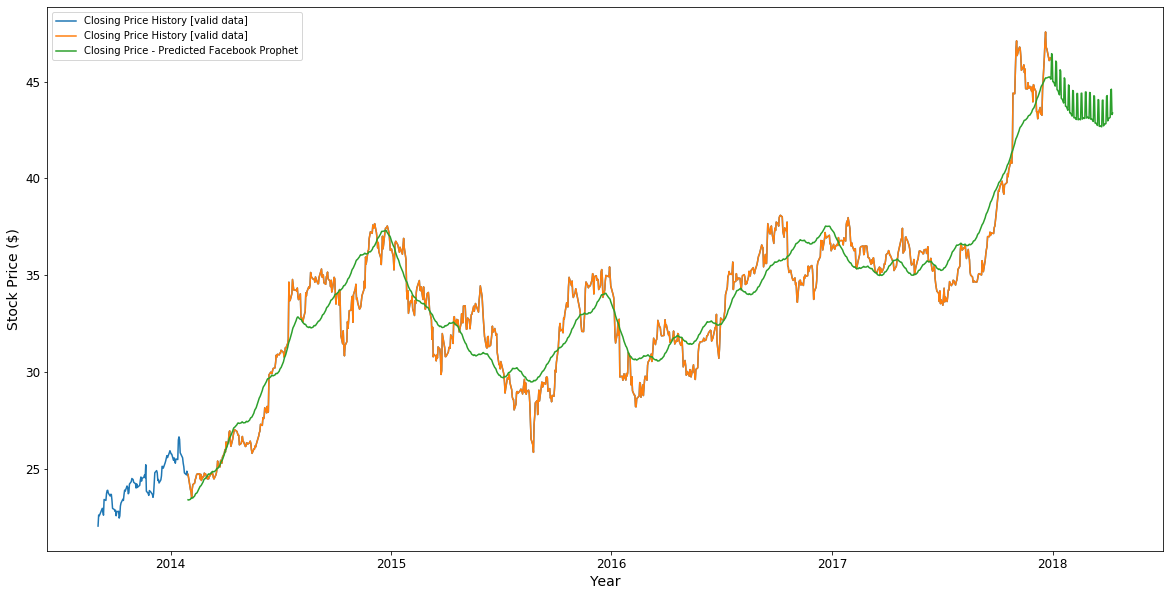

In [34]:
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(df['Date'], df['Close'], label = 'Closing Price History [valid data]')
plt.plot(train['ds'], train['y'], label = 'Closing Price History [valid data]')
plt.plot(forecast['ds'], forecast['yhat'], label = 'Closing Price - Predicted Facebook Prophet')
plt.legend(loc = "upper left")
plt.show()

Adding Custom Seasonalities
In Prophet we can model custom seasonalities using the functions Prophet.add_seasonality.
By default Prophet automatically models a additive daily, weekly, yearly seasonalities based on available training data.
We can get the details of inferred seasonalities using the function Prophet.seasonalities
Let us now use the above method to model a monthly seasonality.

In [35]:
# Modelling a custom monthly seasonality
model2 = Prophet()
model2.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)
model2.fit(train)
forecast2 = model2.predict(close_prices)
print(model2.seasonalities)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OrderedDict([('custom_monthly', {'period': 30.5, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])


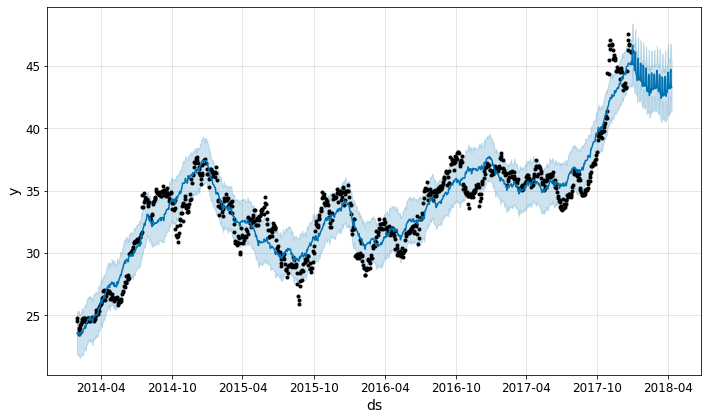

In [36]:
fig1 = model2.plot(forecast2, uncertainty=True)

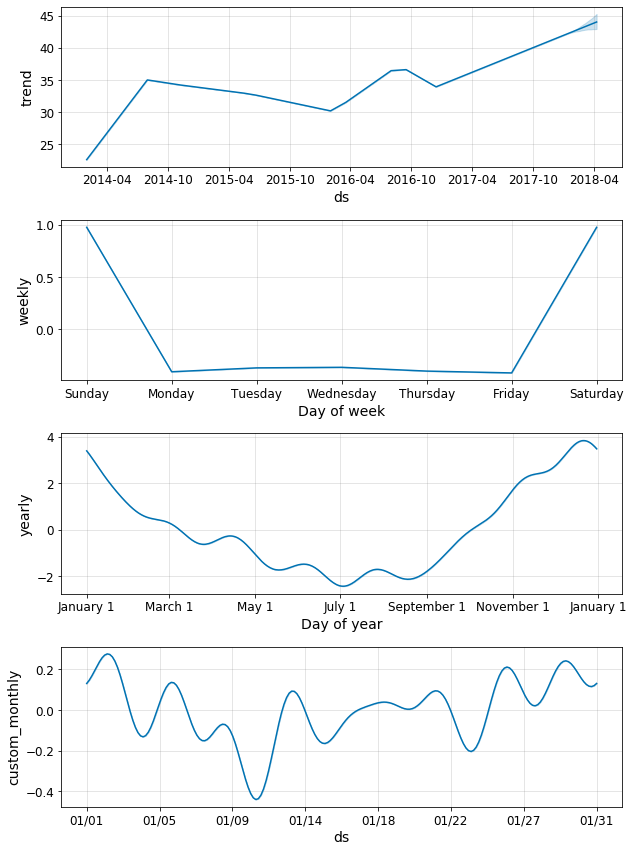

In [37]:
fig2 = model2.plot_components(forecast2, uncertainty=True)

From the above graph We can see that the Prophet has modeled a custom_monthly seasonality and the forecast is also a bit modified compared to the default forecast.

#### Adding External Regressors
Till now the prophet model is not able to model some of points in the training data. We know that these values deviate from the regular value because of the external regressors (regr1, regr2).
let us now see how to capture these values and model them.
Similar to seasonalities prophet also has a way to capture/model external factors which have an effect on the target value using the function Prophet.add_regressors.
In the sample data we are using we have mentioned that there are two external regressors which are effecting the target value.
In order to model and predict the regressor effects, both the training and prediction dataframes should contain the regressor data.
Let us now see how to model these regressors using the above function.
Note : The regressor’s should be numeric values, you will have to perform one hot encoding if the regressor contains string data.

In [38]:
# adding regressor data in historical and future dates
df_train3 = (df[['ds', 'y', 'regr1', 'regr2']]
             .iloc[:150]
             .copy())
df_predict3 = df[['ds', 'regr1', 'regr2']].copy()
# modelling external regressors prior to model fitting
model3 = Prophet()
model3.add_regressor('regr1')
model3.add_regressor('regr2')


# fit and predcit
model3.fit(df_train3)
forecast3 = model3.predict(df_predict3)
# Plot the forecast
fig1 = model3.plot(forecast3, uncertainty=True)

KeyError: "None of [Index(['ds', 'y', 'regr1', 'regr2'], dtype='object')] are in the [columns]"

In [ ]:
# plot model components
fig2 = model3.plot_components(forecast3, uncertainty=True)

From the above output we can observe that the model has pretty much captured the two external effects, from the ouptut graph we can that there is approx 5% and 20% lift on the target value w.r.t the regressors.
Prophet Posterior Samples
By default prophet generates 1000 posterior samples for each day inorder to estimating the upper and lower bound’s of the uncertainity bands. On a given day the mean of the posterior samples is almost equal to the forecast value yhat
Prophet has a way to access the posterior samples for a particular day both in history and future using the function Prophet.predictive_samples
We can modify the no of samples at the time of prophet instantiation using the parameter uncertainty_samples
let us now generate a data frame with posterior samples for 1 week in the prediction data frame.

In [ ]:
# Select one week from prediction df
df_1wk = df_predict3.iloc[:7]
df_1wk

In [ ]:
# fetching the posterior samples.
samples = model3.predictive_samples(df_1wk)
df_samples = pd.DataFrame(data=samples['yhat'], index=df_1wk['ds']).reset_index()
df_samples